# load image

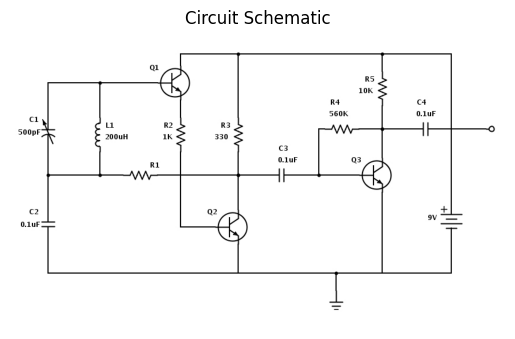

In [4]:
import cv2
import matplotlib.pyplot as plt

# Specify the image path
image_path = r"C:\Users\Test User\Desktop\bring ckt to life - project\simple\ckt schematic\AM-Receiver.webp"

# Read the image
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error: Image not found or the path is incorrect")
else:
    # Convert BGR (OpenCV format) to RGB (Matplotlib format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the image using matplotlib
    plt.imshow(image_rgb)
    plt.title('Circuit Schematic')
    plt.axis('off')  # Hide axes
    plt.show()


# image preprocessing

# template matching

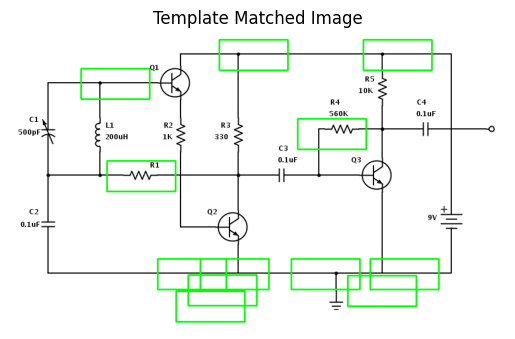

In [23]:
import cv2

# Load the main image and the template image
template_path = r"C:\Users\Test User\Desktop\bring ckt to life - project\templates\resistor.jpg"

# Read the main image and the template image
main_image = image
template = cv2.imread(template_path)

# Convert both images to grayscale (template matching works better in grayscale)
gray_main_image = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

# Get the dimensions of the template
w, h = gray_template.shape[::-1]

# Perform template matching
result = cv2.matchTemplate(gray_main_image, gray_template, cv2.TM_CCOEFF_NORMED)

# Set a threshold for matching
threshold = 0.15  # Higher means more strict matching

# Get the location of the best match
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

# If the best match exceeds the threshold, annotate the image
if max_val >= threshold:
    # Draw a rectangle around the matched region
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(main_image, top_left, bottom_right, (0, 255, 0), 2)
    
     # Convert BGR to RGB for matplotlib
    annotated_image_rgb = cv2.cvtColor(main_image, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.imshow(annotated_image_rgb)
    plt.title('Template Matched Image')
    plt.axis('off')  # Hide the axes
    plt.show()
    
else:
    print("No match found above the threshold")


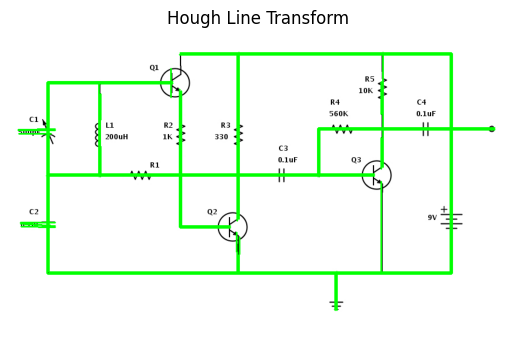

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (you can replace this with your masked portion)
image_path = r"C:\Users\Test User\Desktop\bring ckt to life - project\simple\ckt schematic\AM-Receiver.webp"
image = cv2.imread(image_path)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Perform Canny edge detection
edges = cv2.Canny(blurred, 50, 150)
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))


# Perform Hough Line Transform
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=10, minLineLength=50, maxLineGap=10)

# If lines are detected, draw them on the image
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]  # Extract coordinates of the detected line
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw the line (in green)

# Convert BGR to RGB for displaying with matplotlib
annotated_image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the original image with the detected lines
plt.imshow(annotated_image_rgb)
plt.title('Hough Line Transform')
plt.axis('off')  # Hide the axes
plt.show()


# PySpice

In [29]:
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

circuit = Circuit('Resistor Bridge')

circuit.V('input', 1, circuit.gnd, 10@u_V)
circuit.R(1, 1, 2, 2@u_kΩ)
circuit.R(2, 1, 3, 1@u_kΩ)
circuit.R(3, 2, circuit.gnd, 1@u_kΩ)
circuit.R(4, 3, circuit.gnd, 2@u_kΩ)
circuit.R(5, 3, 2, 2@u_kΩ)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.operating_point()
# analysis = simulator.transient(step_time=source.period/200, end_time=source.period*2)


for node in analysis.nodes.values():
    print('Node {}: {:4.1f} V'.format(str(node), float(node))) # Fixme: format value + unit

Node 3:  6.0 V
Node 2:  4.0 V
Node 1: 10.0 V


C:\Users\TestUser\AppData\Local\Temp\ipykernel_10788\4225086426.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Node {}: {:4.1f} V'.format(str(node), float(node))) # Fixme: format value + unit


ValueError: x, y, and format string must not be None

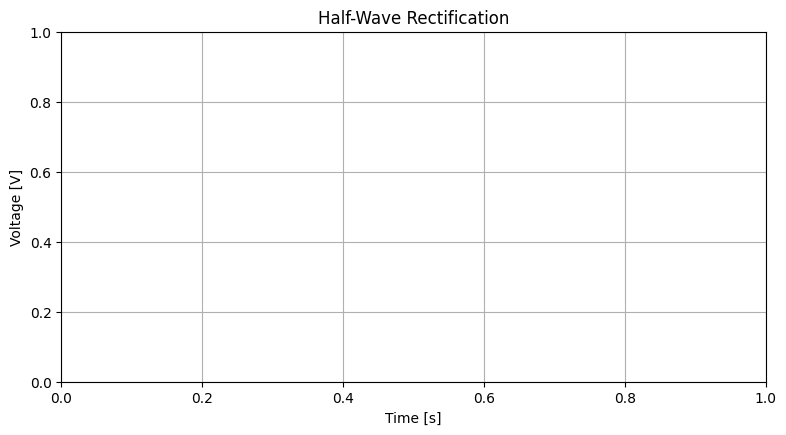

In [33]:
import matplotlib.pyplot as plt


import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *


# libraries_path = "./spice_lib"
# spice_library = SpiceLibrary(libraries_path)


figure1 = plt.figure(1, (20, 10))


circuit = Circuit('half-wave rectification')
circuit.include("1N4148.lib")
source = circuit.SinusoidalVoltageSource('input', 'in', circuit.gnd, amplitude=10@u_V, frequency=50@u_Hz)
circuit.X('D1', '1N4148', 'in', 'output')
circuit.R('load', 'output', circuit.gnd, 100@u_Ω)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=source.period/200, end_time=source.period*2)
# analysis = simulator.operating_point()

axe = plt.subplot(221)
plt.title('Half-Wave Rectification')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plot(analysis['2'], axis=axe)
plot(analysis['1'], axis=axe)
plt.legend(('input', 'output'), loc=(.05,.1))
plt.ylim(float(-source.amplitude*1.1), float(source.amplitude*1.1))

In [36]:
analysis['2'].abscissa

In [18]:
# Fixme: Complete


import numpy as np
import matplotlib.pyplot as plt


import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *


libraries_path = find_libraries()
spice_library = SpiceLibrary(libraries_path)


figure = plt.figure(1, (20, 10))

<Figure size 2000x1000 with 0 Axes>

tau=10m


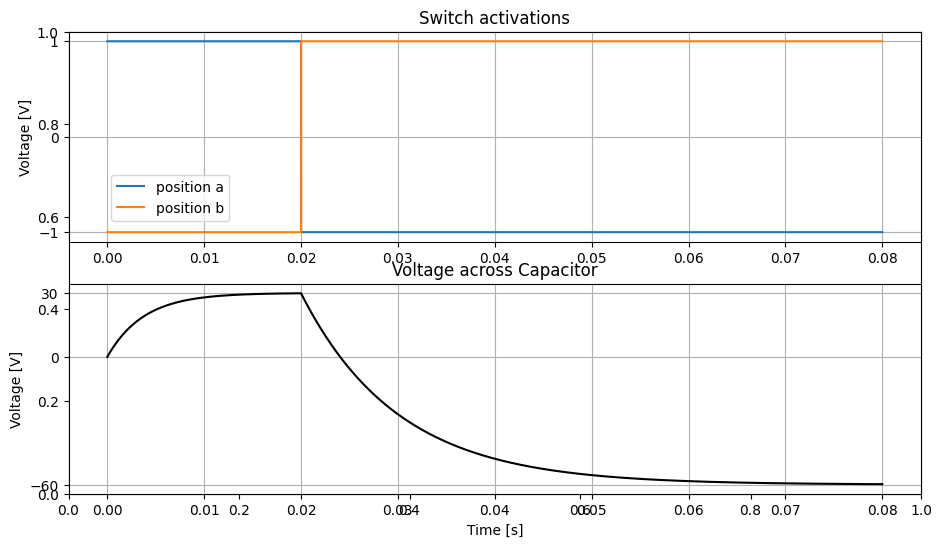

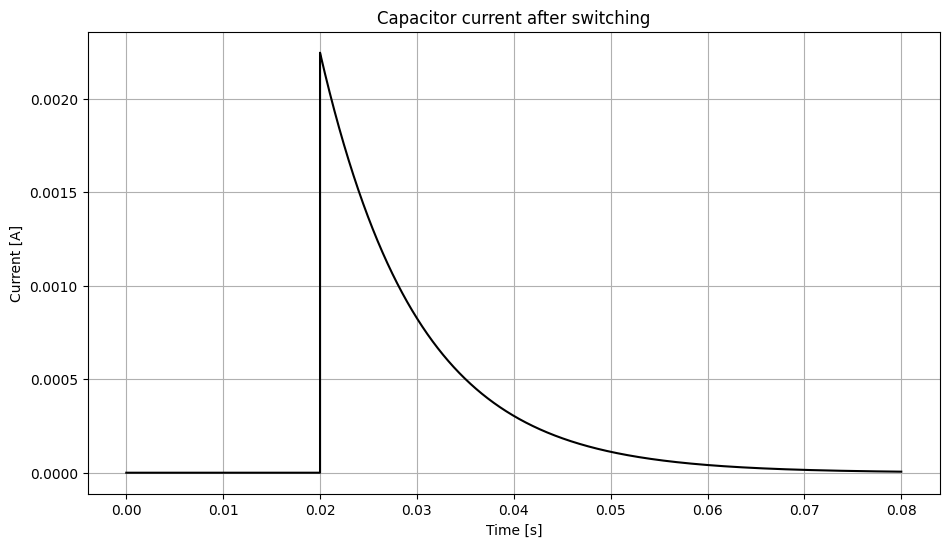

In [1]:
# Pyspice (Python) code to simulate RC Step Response.
#####################################################################
# STANDARD DECLARATIONS

import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
import numpy as np

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

import math
from engineering_notation import EngNumber

#####################################################################
# CIRCUIT NETLIST
circuit = Circuit('Step Response of RC Circuit')

steptime=1@u_us
switchingtime=20@u_ms
finaltime = 80@u_ms

circuit.model('switch', 'SW', Ron=1@u_mΩ, Roff=1@u_GΩ)

circuit.PulseVoltageSource(3, 'posa', circuit.gnd,initial_value=1, pulsed_value=-1,
                           pulse_width=finaltime, period=finaltime, delay_time=switchingtime)
circuit.R('testa', 'posa', circuit.gnd, 1@u_kΩ)

circuit.PulseVoltageSource(4, 'posb', circuit.gnd,initial_value=-1, pulsed_value=1,
                           pulse_width=finaltime, period=finaltime, delay_time=switchingtime)
circuit.R('testb', 'posb', circuit.gnd, 1@u_kΩ)

circuit.V(1, 1, circuit.gnd,   40@u_V)
circuit.R(1, 1, 'a',          20@u_kΩ)
circuit.R(2, 'a', circuit.gnd, 60@u_kΩ)
circuit.VoltageControlledSwitch(1, 'a', 'output','posa', circuit.gnd, model='switch')
circuit.C(1, 'output', circuit.gnd, 0.25@u_uF)
circuit.VoltageControlledSwitch(2, 'output', 'b', 'posb', circuit.gnd, model='switch')
circuit.R(3, 'b', 2,           8@u_kΩ)
circuit.R(4, 2, circuit.gnd, 160@u_kΩ)
circuit.R(5, 2, 3,            40@u_kΩ)
circuit.V(2, circuit.gnd, 3,   75@u_V)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
ic=0@u_V
simulator.initial_condition(output=ic)
analysis = simulator.transient(step_time=steptime, end_time=finaltime)

#######################################################################
# THEORETICAL CALCULATIONS

# Time constant after switching
tau =(circuit.C1.capacitance)*(circuit.R3.resistance +
                                 (circuit.R4.resistance)*(circuit.R5.resistance)
                                 /(circuit.R4.resistance+ circuit.R5.resistance))
print('tau={0}'.format(EngNumber(tau.value)))


#######################################################################
# PLOTTING COMMANDS

figure = plt.subplots(figsize=(11, 6))

axe = plt.subplot(211)
plt.title('Switch activations')
#plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plot(analysis['posa'], axis=axe)
plot(analysis['posb'], axis=axe)
plt.legend(('position a', 'position b'), loc=(.05,.1))
axe.set_yticks([-1, 0, 1])

axe = plt.subplot(212)
plt.title('Voltage across Capacitor')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()
plot(analysis['output'], axis=axe, color='black')
#plt.legend(('Voltage'), loc=(.05,.1))
axe.set_yticks([-60, 0, 30])
cursor = Cursor(axe, useblit=True, color='red', linewidth=1)


figure, axe= plt. subplots(figsize=(11, 6))
plt.title('Capacitor current after switching')
plt.xlabel('Time [s]')
plt.ylabel('Current [A]')
plt.grid()
plot((analysis['b']-analysis['2'])/circuit.R3.resistance, axis=axe, color='black')

plt.show()


In [76]:
from PySpice.Spice.Netlist import Circuit


circuit = Circuit("my first ckt")

init_time = 0 @u_s
final_time = 800 @u_ms

circuit.V("input", 1, circuit.gnd, 50 @u_V)
circuit.R(1, 1, 2, 500)
circuit.C(1, 2, circuit.gnd, 3 @u_uF)
circuit.L(2, 2, circuit.gnd, 1 @u_mH)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.operating_point()




In [99]:
circuit['R1'].resistance = 5
circuit['R1'].resistance

5

In [77]:
for node in analysis.nodes.values():
    print(f"{str(node)} {float(node)}V")
    
for branch in analysis.branches.values():
    print(f"{str(branch)} {float(branch)}A")

2 0.0V
1 50.0V
vinput -0.1A
l2 0.1A


C:\Users\TestUser\AppData\Local\Temp\ipykernel_10788\1758099204.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"{str(node)} {float(node)}V")
C:\Users\TestUser\AppData\Local\Temp\ipykernel_10788\1758099204.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"{str(branch)} {float(branch)}A")


In [70]:
analysis.branches['vinput']

WaveForm vinput [-0.0125]@A

In [72]:
print(str(circuit))

.title my first ckt
Vinput 0 1 50V
R1 1 2 3kOhm
R2 2 0 1kOhm

